<!-- SPDX-License-Identifier: AGPL-3.0-only
Copyright (c) 2025 Marco Mongi -->
# Objective
The goal of this notebook is to develop the main processing flow for the AutoCBC system:

> Input Image -> YOLO Detector -> SAM 2 Segmentation -> Output Masks

# Download Model and input image
Both will be obtained from the [training repository](https://github.com/marcoom/yolo-auto-cbc-training)

**Test images**

In [1]:
# Test image
!wget -O test1.png "https://raw.githubusercontent.com/marcoom/yolo-auto-cbc-training/main/test/images/1299047edeb15e2581d9680aaa667d5d.png"
!wget -O test2.png "https://raw.githubusercontent.com/marcoom/yolo-auto-cbc-training/main/test/images/00552f60c43350a0bf516cfbc13db058.png"
!wget -O test3.png "https://raw.githubusercontent.com/marcoom/yolo-auto-cbc-training/main/test/images/3af3aa6cc3a359a4aca25b09077342cd.png"

--2025-10-15 16:29:33--  https://raw.githubusercontent.com/marcoom/yolo-auto-cbc-training/main/test/images/1299047edeb15e2581d9680aaa667d5d.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16083 (16K) [image/png]
Saving to: ‘test1.png’

test1.png           100%[===================>]  15.71K  --.-KB/s    in 0.001s  

2025-10-15 16:29:33 (27.6 MB/s) - ‘test1.png’ saved [16083/16083]

--2025-10-15 16:29:33--  https://raw.githubusercontent.com/marcoom/yolo-auto-cbc-training/main/test/images/00552f60c43350a0bf516cfbc13db058.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP reques

In [2]:
TEST_IMAGE = "test1.png"

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

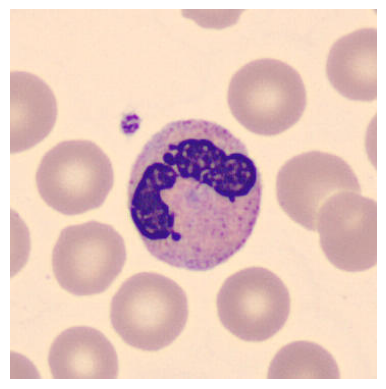

In [4]:
img_pil = Image.open(TEST_IMAGE)
img_np = np.array(img_pil) # Convert PIL image to NumPy array

# Display the image using matplotlib
plt.imshow(img_np)
plt.axis('off') # Optional: turn off axis labels
plt.show()

**Trained model**

In [5]:
# Trained model
!wget https://raw.githubusercontent.com/marcoom/yolo-auto-cbc-training/main/runs/detect/train/weights/best.pt

--2025-10-15 16:29:34--  https://raw.githubusercontent.com/marcoom/yolo-auto-cbc-training/main/runs/detect/train/weights/best.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5508954 (5.3M) [application/octet-stream]
Saving to: ‘best.pt’

best.pt             100%[===================>]   5.25M  --.-KB/s    in 0.06s   

2025-10-15 16:29:35 (86.6 MB/s) - ‘best.pt’ saved [5508954/5508954]



# Detection
The goal here is to detect the WBC, RBC and platelets on the test image using the trained YOLO detection model

## Load model

In [6]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00


In [7]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
# Load a model
det_model = YOLO("best.pt")  # pretrained YOLO11n model

## Perform inference

In [9]:
# Run detection
det_results = det_model.predict(TEST_IMAGE, save=True, conf=0.5, iou=0.7)  # return detection results in a list format (one element for each input image)

detection = det_results[0] # as we only have 1 image, we will keep the first element of the list



image 1/1 /content/test1.png: 640x640 1 WBC, 11 RBCs, 1 Platelet, 31.5ms
Speed: 19.1ms preprocess, 31.5ms inference, 902.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict


## Show results

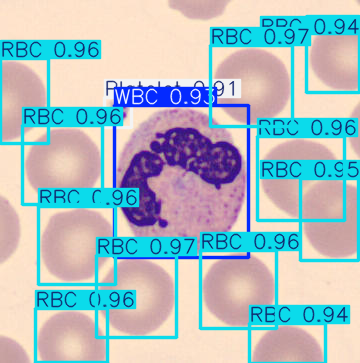

'det_result.png'

In [10]:
detection.show()  # display to screen
detection.save(filename="det_result.png")  # save to disk

## Count cells by type

First, we define a function that returns a dictionary with the count of detected cells for each type

In [11]:
def count_cells(detection):
  """
  Counts the number of detected cells by type.

  Args:
    detection: The detection object from YOLO model prediction.

  Returns:
    A dictionary where keys are cell type names and values are their counts.
  """
  class_ids = list(detection.names.keys())
  counts = {}
  for class_id in class_ids:
    class_name = detection.names.get(class_id)
    count = (detection.boxes.cls == class_id).sum().item()
    counts[class_name] = count

  return counts

In [12]:
cell_counts_dict = count_cells(detection)
print(cell_counts_dict)

{'WBC': 1, 'RBC': 11, 'Platelet': 1}


Plot results in a pie chart for ease of visualization

In [13]:
import plotly.express as px
import pandas as pd

def plot_count_pie_chart(cell_counts_dict):
    """
    Plots a pie chart of cell counts.

    Args:
      cell_counts_dict: A dictionary where keys are cell type names and values are their counts.
    """

    df_counts = pd.DataFrame(list(cell_counts_dict.items()), columns=['Cell Type', 'Count'])

    # Define custom colors
    color_map = {'RBC': 'rgb(255, 100, 100)', 'WBC': 'rgb(255, 255, 100)', 'Platelet': 'rgb(100, 100, 255)'}

    fig = px.pie(df_counts,
                 values='Count',
                 names='Cell Type',
                 title='Percentage and Count of Detected Cell Types',
                 color='Cell Type',
                 color_discrete_map=color_map,
                 hover_data=['Count'],
                 labels={'Count':'Count'})

    # Update traces to show text inside, set hover template, and customize text appearance
    fig.update_traces(textposition='inside',
                      textinfo='percent+label+value', # Show percentage, label (name), and value (count)
                      hovertemplate='<b>%{label}</b>: %{value} (%{percent})<extra></extra>') # Customize hover template

    fig.update_layout(showlegend=False)

    fig.show()

In [14]:
plot_count_pie_chart(cell_counts_dict)

# Segmentation
The goal of this section is to get the pixels for each cell in the input image, where each cell is delimited by a bounding box from the detection process

## Load model

In [15]:
from ultralytics import SAM

# Load a model
seg_model = SAM("sam2.1_t.pt")

# Display model information (optional)
seg_model.info()

Model summary: 307 layers, 38,962,498 parameters, 38,962,498 gradients


(307, 38962498, 38962498, 0.0)

## Perform inference

In [16]:
# Run inference with bboxes prompt
seg_results = seg_model(TEST_IMAGE, bboxes=detection.boxes.xyxy)

segmentation = seg_results[0]


image 1/1 /content/test1.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 532.2ms
Speed: 5.5ms preprocess, 532.2ms inference, 33.7ms postprocess per image at shape (1, 3, 1024, 1024)


## Show results

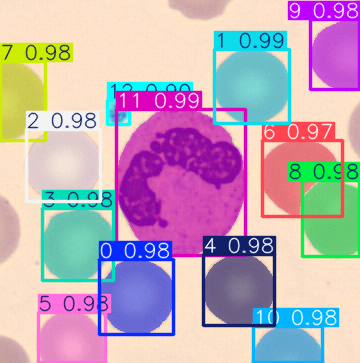

'seg_result.png'

In [17]:
segmentation.show()  # display to screen
segmentation.save(filename="seg_result.png")  # save to disk

# Image overlay
We have all the necessary information, we only need to present it to the user in a clear and intuitive way

The original image will be shown as a base, and the segmentation results will be shown as an overlay with an alpha blending (the color of the overlay will be determined by the cell type). Also, background can be removed

In [18]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [19]:
# Pastel palette
COLORS = {
    'RBC':        np.array([255, 150, 150], dtype=np.uint8),  # pastel red
    'WBC':        np.array([255, 255, 150], dtype=np.uint8),  # yellow
    'Platelet':   np.array([150, 180, 255], dtype=np.uint8),  # pastel blue
    'Background': np.array([0, 0, 0], dtype=np.uint8),        # black
}

Define some functions

In [20]:
def _find_class_id(names_dict, target_name):
    target = target_name.strip().lower()
    for cid, name in names_dict.items():
        if str(name).strip().lower() == target:
            return int(cid)
    return None

def _resize_mask_bool(mask_bool, target_hw):
    h, w = target_hw
    if mask_bool.shape == (h, w):
        return mask_bool
    m = (mask_bool.astype(np.uint8) * 255)
    m_resized = Image.fromarray(m).resize((w, h), resample=Image.NEAREST)
    return (np.array(m_resized) > 127)

def _darken(color_rgb_uint8, factor=0.7):
    """Darken an RGB uint8 color by factor (0..1)."""
    return np.clip(color_rgb_uint8.astype(np.float32) * float(factor), 0, 255).astype(np.uint8)

def _make_border(mask_bool, width_px):
    """
    Inner border of given pixel width using erosion.
    border = mask & ~erode(mask, iterations=width_px)
    """
    if width_px <= 0:
        return np.zeros_like(mask_bool, dtype=bool)
    m = (mask_bool.astype(np.uint8) * 255)
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(m, kernel, iterations=int(width_px))
    border = cv2.bitwise_and(m, cv2.bitwise_not(eroded))
    return border > 0

def build_class_masks(detection, segmentation, img_shape_hw):
    # SAM masks -> numpy bool (N, Hm, Wm)
    masks_t = segmentation.masks.data  # torch.Tensor [N, Hm, Wm]
    masks_np = masks_t.cpu().numpy().astype(bool)

    # Class IDs for each bbox (same order as bboxes passed to SAM)
    cls_ids = detection.boxes.cls.cpu().numpy().astype(int)

    n = min(len(cls_ids), masks_np.shape[0])
    masks_np = masks_np[:n]
    cls_ids = cls_ids[:n]

    names = detection.names
    rbc_id = _find_class_id(names, 'RBC')
    wbc_id = _find_class_id(names, 'WBC')
    pl_id  = _find_class_id(names, 'Platelet')

    if any(x is None for x in [rbc_id, wbc_id, pl_id]):
        raise ValueError(
            f"Expected class names not found in detection.names: {names}. "
            "Adjust _find_class_id if your model uses different labels."
        )

    H, W = img_shape_hw
    rbc_mask = np.zeros((H, W), dtype=bool)
    wbc_mask = np.zeros((H, W), dtype=bool)
    pl_mask  = np.zeros((H, W), dtype=bool)

    for i in range(n):
        cid = int(cls_ids[i])
        m = _resize_mask_bool(masks_np[i], (H, W))
        if cid == rbc_id:
            rbc_mask |= m
        elif cid == wbc_id:
            wbc_mask |= m
        elif cid == pl_id:
            pl_mask  |= m

    union = rbc_mask | wbc_mask | pl_mask
    bg_mask = ~union  # Background = pixels that belong to no cell

    return rbc_mask, wbc_mask, pl_mask, bg_mask

def render_overlay(
    img_rgb,
    rbc_mask, wbc_mask, pl_mask, bg_mask,
    show_rbc=True, show_wbc=True, show_platelet=True, show_bg=False,
    alpha=0.35,
    draw_borders=True,
    border_width=2,
    border_darken_factor=0.7
):
    """
    Returns:
      - out_rgb: base image + overlay with alpha applied only where overlay is present
      - overlay_rgb: overlay-only image (flat), useful for debug/saving
    Notes:
      - Borders are drawn in the same hue but darkened by `border_darken_factor`.
      - Border width is measured in pixels and applied as an inner border.
      - If masks overlap, later assignments override earlier ones (order: RBC -> WBC -> Platelet -> Background).
    """
    H, W = img_rgb.shape[:2]
    overlay = np.zeros((H, W, 3), dtype=np.uint8)
    comp_mask = np.zeros((H, W), dtype=bool)

    # Helper to paint fill + optional border for one class
    def _paint(mask_bool, base_color):
        nonlocal overlay, comp_mask
        if not np.any(mask_bool):
            return
        # Fill
        overlay[mask_bool] = base_color
        comp_mask |= mask_bool

        # Border (inner)
        if draw_borders and border_width > 0:
            border_mask = _make_border(mask_bool, border_width)
            if np.any(border_mask):
                overlay[border_mask] = _darken(base_color, border_darken_factor)
                comp_mask |= border_mask

    if show_rbc:
        _paint(rbc_mask, COLORS['RBC'])
    if show_wbc:
        _paint(wbc_mask, COLORS['WBC'])
    if show_platelet:
        _paint(pl_mask, COLORS['Platelet'])
    if show_bg:
        # Background has no border
        overlay[bg_mask] = COLORS['Background']
        comp_mask |= bg_mask

    # Alpha blend only where overlay is present
    out = img_rgb.copy().astype(np.float32)
    overlay_f = overlay.astype(np.float32)
    mask3 = np.stack([comp_mask]*3, axis=-1)

    out[mask3] = (1.0 - alpha) * out[mask3] + alpha * overlay_f[mask3]
    out = np.clip(out, 0, 255).astype(np.uint8)

    return out, overlay

Configure execution

In [21]:
alpha = 0.80
show_rbc = True
show_wbc = True
show_platelet = True
show_bg = False

draw_borders = True       # toggle borders
border_width = 3          # pixels
border_darken_factor = 0.7  # 0..1 (lower = darker)

Execute

In [23]:
H, W = img_np.shape[:2]
rbc_mask, wbc_mask, pl_mask, bg_mask = build_class_masks(detection, segmentation, (H, W))

out_img, overlay_only = render_overlay(
    img_np,
    rbc_mask, wbc_mask, pl_mask, bg_mask,
    show_rbc=show_rbc,
    show_wbc=show_wbc,
    show_platelet=show_platelet,
    show_bg=show_bg,
    alpha=alpha,
    draw_borders=draw_borders,
    border_width=border_width,
    border_darken_factor=border_darken_factor
)

Visualize results

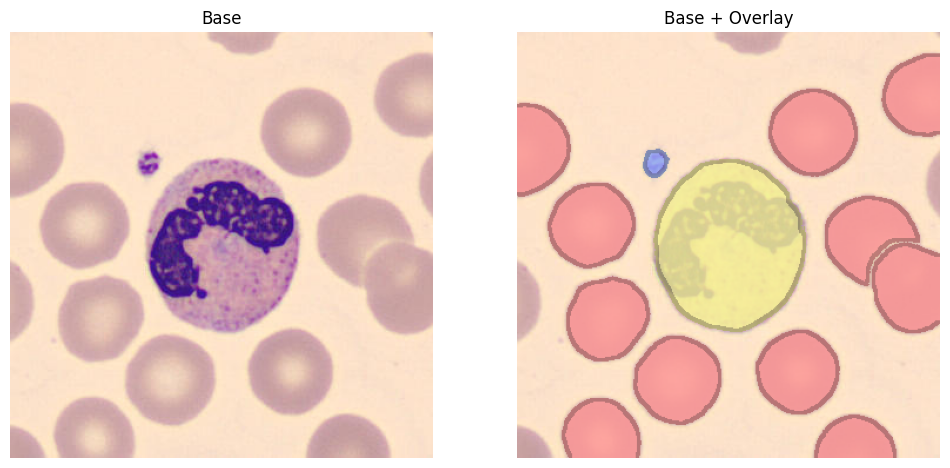

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.title("Base"); plt.imshow(img_np); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("Base + Overlay"); plt.imshow(out_img); plt.axis('off')
plt.show()